In [2]:
import pandas as pd
df = pd.read_csv("../data/processed/feature_engineered_data.csv")
df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,hour_mod24,is_night,is_business_hours,log_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,1,0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,1,0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,1,0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,1,0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,1,0,4.262539


In [3]:
features = [col for col in df.columns if col.startswith("V")] + ["hour_mod24", "is_night", "is_business_hours", "log_amount"]
labels = "Class"

In [4]:
df = df.sort_values(by='Time')

In [15]:
import yaml
with open("../config/config.yaml") as f:
    cfg = yaml.safe_load(f)

In [18]:
from sklearn.model_selection import train_test_split
cut = int(cfg["training"]["train_size"] * len(df))
train_df, test_df = df.iloc[:cut], df.iloc[cut:]

# Inner validation from train (time-ordered)
cut_in = int(cfg["training"]["train_size"] * len(train_df))
train__df, val_df = train_df.iloc[:cut_in], train_df.iloc[cut_in:]

X_train , y_train = train__df[features], train__df[labels].astype(int)
X_val   , y_val   = val_df[features]  , val_df[labels].astype(int)
X_test  , y_test  = test_df[features] , test_df[labels].astype(int)

In [19]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(181584, 32) (45396, 32) (56746, 32)
(181584,) (45396,) (56746,)


In [22]:
import joblib
model = joblib.load("../"+cfg["paths"]["models"]+"/fraudulent.pkl")

In [25]:
val_xgb_proba  = model.predict_proba(X_val)[:, 1]
test_xgb_proba = model.predict_proba(X_test)[:, 1]

In [31]:
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

def plot_pr_roc(y_true, y_score ,title):
    plt.figure(figsize=(6, 4))
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision)
    plt.axhline(y=y_true.mean(), color='r', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} - PR (AP = {round(average_precision_score(y_true, y_score), 4)})")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC (AUC = {round(roc_auc_score(y_true, y_score), 4)})")
    plt.tight_layout()
    plt.show()

In [27]:
SEED = 42

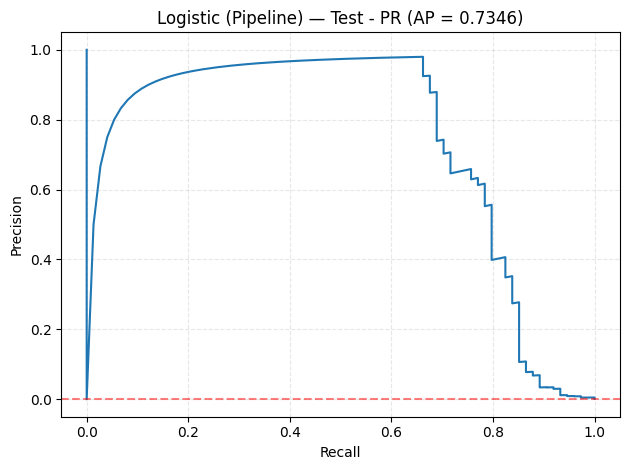

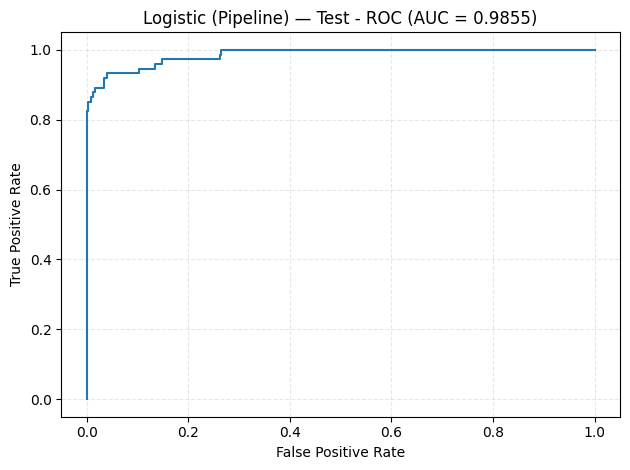

[Logistic|Pipeline] VAL AUPRC: 0.7494284011177816
[Logistic|Pipeline] TEST AUPRC: 0.7345886782169799


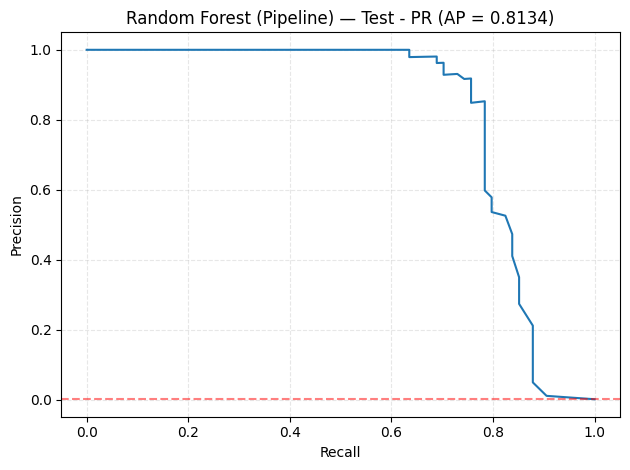

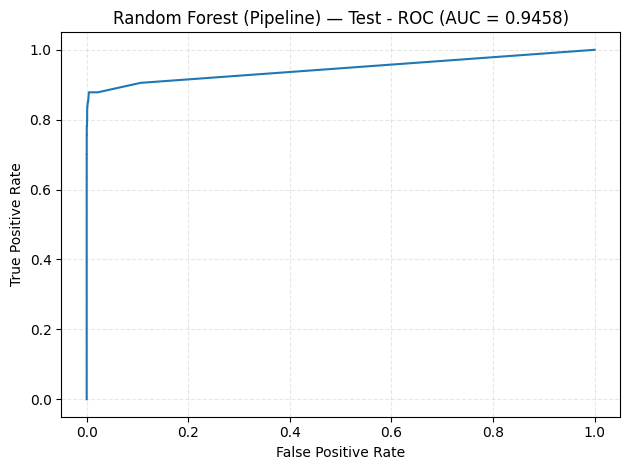

[RF|Pipeline] VAL AUPRC: 0.7545545083077575
[RF|Pipeline] TEST AUPRC: 0.8133922209194309


In [30]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logit_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])
logit_pipe.fit(X_train, y_train)

val_log_proba  = logit_pipe.predict_proba(X_val)[:, 1]
test_log_proba = logit_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_log_proba, "Logistic (Pipeline) — Test")
print("[Logistic|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_log_proba))
print("[Logistic|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_log_proba))

# Random Forest
rf_pipe = ImbPipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train)

val_rf_proba  = rf_pipe.predict_proba(X_val)[:, 1]
test_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_rf_proba, "Random Forest (Pipeline) — Test")
print("[RF|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_rf_proba))
print("[RF|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_rf_proba))

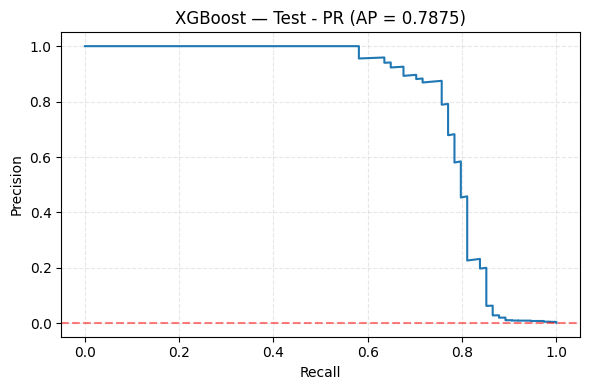

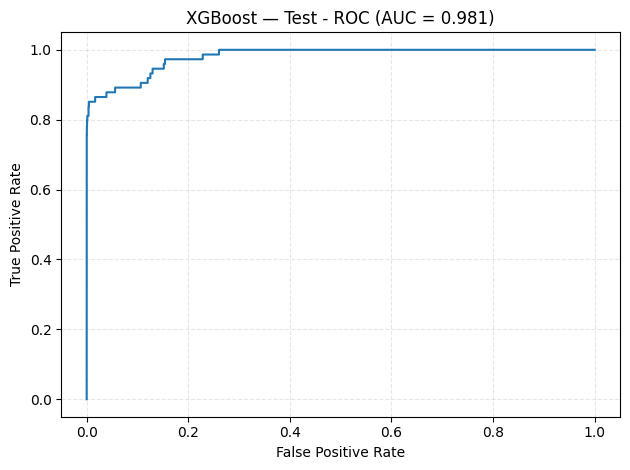

[XGBoost] VAL AUPRC: 0.7464045623319586
[XGBoost] TEST AUPRC: 0.7874846042071628


In [32]:
# XGBoost

val_xgb_proba  = model.predict_proba(X_val)[:, 1]
test_xgb_proba = model.predict_proba(X_test)[:, 1]
plot_pr_roc(y_test, test_xgb_proba, "XGBoost — Test")
print("[XGBoost] VAL AUPRC:",  average_precision_score(y_val , val_xgb_proba))
print("[XGBoost] TEST AUPRC:", average_precision_score(y_test, test_xgb_proba))

In [42]:
import numpy as np
def expected_calibration_error(y_true, y_proba, n_bins=10):
    """
    Calculate the Expected Calibration Error (ECE).

    Args:
        y_true (pd.Series or np.array): True binary labels.
        y_proba (np.array): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to use for calibration.
    Returns:
        float: Expected Calibration Error.
    """

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    # print( bin_edges)
    idx = np.digitize(y_proba, bin_edges) - 1
    # print(idx)
    ece = 0.0
    for i in range(n_bins):
        bin_mask = (idx == i)
        if not np.any(bin_mask):
            continue
        conf = np.mean(y_proba[bin_mask])
        acc = np.mean(y_true[bin_mask])
        ece += np.mean(bin_mask) * np.abs(acc - conf)
        # print(f"Bin {i}: Conf={conf}, Acc={acc}, Weight={np.mean(bin_mask)}")
        # print(ece)
    return ece

In [41]:
ece_xgb = expected_calibration_error(y_test, test_xgb_proba, n_bins=10)
print("XGBoost ECE:", ece_xgb)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0 0 0 ... 0 0 0]
Bin 0: Conf=0.002204339951276779, Acc=0.0002125888001133807, Weight=0.9947309061431643
0.001981256427408458
Bin 1: Conf=0.13910795748233795, Acc=0.015151515151515152, Weight=0.0023261551474993833
0.002269598343802012
Bin 2: Conf=0.24246081709861755, Acc=0.018518518518518517, Weight=0.0009516089239770204
0.0024827038335867605
Bin 3: Conf=0.3425273895263672, Acc=0.037037037037037035, Weight=0.0004758044619885102
0.0026280575063956264
Bin 4: Conf=0.4455123841762543, Acc=0.25, Weight=7.048954992422373e-05
0.0026418390863608226
Bin 5: Conf=0.5388785600662231, Acc=0.0, Weight=0.00014097909984844747
0.0027178097006865863
Bin 6: Conf=0.638846755027771, Acc=0.3333333333333333, Weight=5.28671624431678e-05
0.002733961328379874
Bin 7: Conf=0.7499876022338867, Acc=0.0, Weight=3.524477496211187e-05
0.002760394472644981
Bin 8: Conf=0.8374502062797546, Acc=0.0, Weight=5.28671624431678e-05
0.0028046680887384373
Bin 9: Conf=0.99207526445388

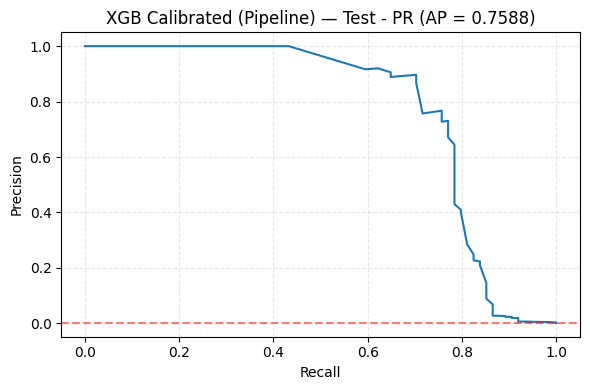

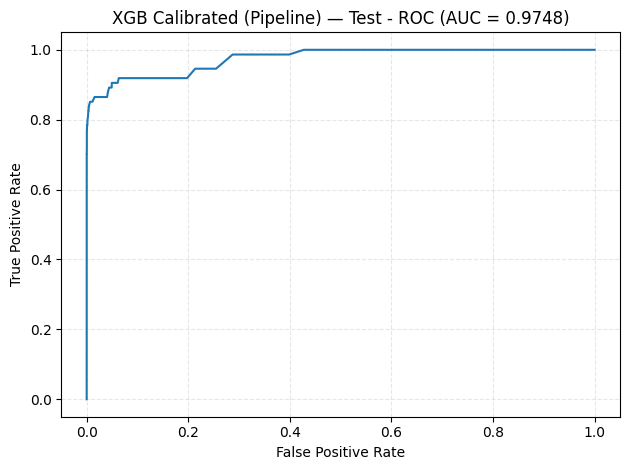

[XGB-Cal|Pipeline] VAL AUPRC: 0.7511636269303887
[XGB-Cal|Pipeline] TEST AUPRC: 0.7587910695817288
ECE[Test] XGB-Cal: 0.0005530957332233978


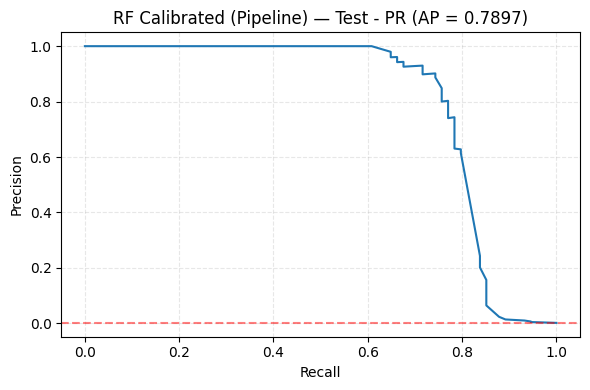

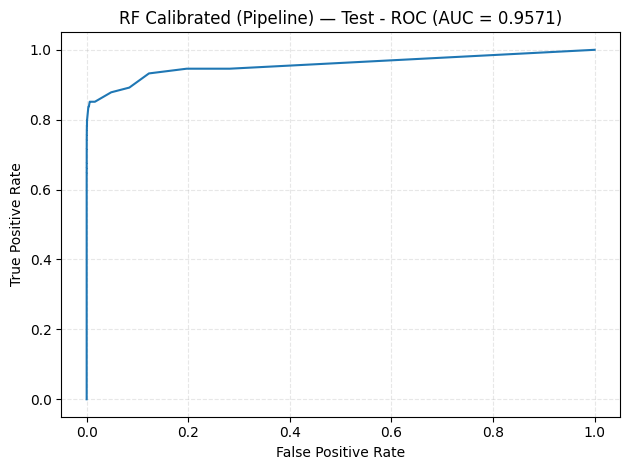

[RF-Cal] VAL AUPRC: 0.7345264671934548
[RF-Cal] TEST AUPRC: 0.7897245095383505
ECE[Test] RF-Cal : 0.000273369361040701


In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV

cal_cv = TimeSeriesSplit(n_splits=3)

# Calibrated XGB
xgb_cal = CalibratedClassifierCV(estimator=model, method="isotonic", cv=cal_cv)
xgb_cal.fit(X_train, y_train)
val_xgb_cal  = xgb_cal.predict_proba(X_val)[:, 1]
test_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_xgb_cal, "XGB Calibrated (Pipeline) — Test")
print("[XGB-Cal|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_cal))
print("[XGB-Cal|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_cal))
print("ECE[Test] XGB-Cal:", expected_calibration_error(y_test.values, test_xgb_cal, n_bins=15))


# Calibrated RF
rf_cal = CalibratedClassifierCV(estimator=rf_pipe, method="isotonic", cv=cal_cv)
rf_cal.fit(X_train, y_train)
val_rf_cal  = rf_cal.predict_proba(X_val)[:, 1]
test_rf_cal = rf_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_rf_cal, "RF Calibrated (Pipeline) — Test")
print("[RF-Cal] VAL AUPRC:",  average_precision_score(y_val,  val_rf_cal))
print("[RF-Cal] TEST AUPRC:", average_precision_score(y_test, test_rf_cal))
print("ECE[Test] RF-Cal :", expected_calibration_error(y_test.values, test_rf_cal,  n_bins=15))

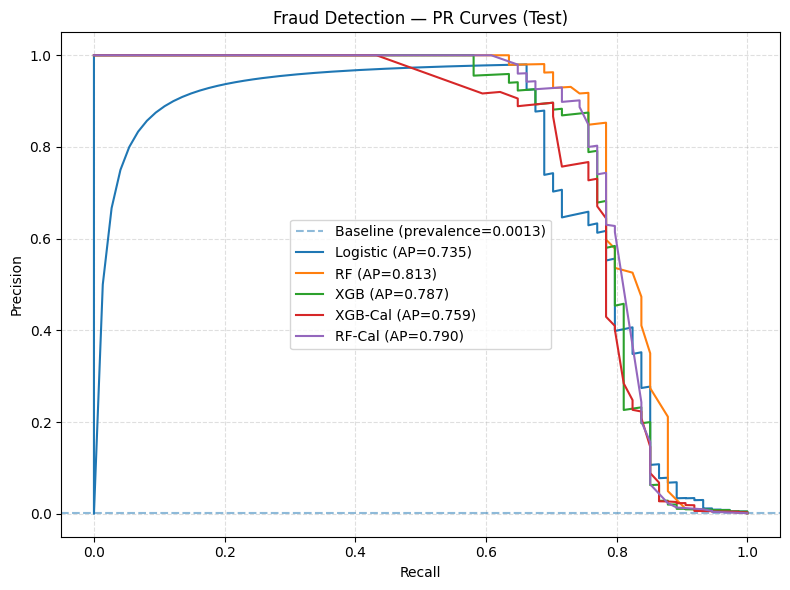

In [44]:
def plot_pr_overlay(y_true, preds_dict, title="PR Curves — Overlay"):
    plt.figure(figsize=(8,6))
    base = y_true.mean()
    plt.axhline(base, ls="--", alpha=0.5, label=f"Baseline (prevalence={base:.4f})")
    
    for name, y_prob in preds_dict.items():
        ps, rs, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rs, ps, label=f"{name} (AP={ap:.3f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

preds_test = {
    "Logistic":        test_log_proba,
    "RF":              test_rf_proba,
    "XGB":             test_xgb_proba,
    "XGB-Cal":         test_xgb_cal,
        "RF-Cal":          test_rf_cal,
}
plot_pr_overlay(y_test, preds_test, title="Fraud Detection — PR Curves (Test)")

**Threshold Tuning XGB-Cal**

In [46]:
COST_FP = 5.0     # investigation cost per false alert
COST_FN = 200.0

def thr_for_precision(y_true, y_score, target_p=0.90):
    ps, rs, ths = precision_recall_curve(y_true, y_score)
    hits = np.where(ps[:-1] >= target_p)[0]
    if hits.size:
        i = hits[0]
        return float(ths[i]), float(ps[i]), float(rs[i])
    i = np.argmax(0.5*ps[:-1] + 0.5*rs[:-1])  
    return float(ths[i]), float(ps[i]), float(rs[i])


def thr_min_cost(y_true , y_score , cost_fp=COST_FP , cost_fn=COST_FN, grid=1001):
    best_thr , best_cost = 0.5, float("inf")
    for t in np.linspace(0,1, grid):
        yhat = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true ,yhat, labels=[0,1]).ravel()
        cost = fp*cost_fp + fn*cost_fn
        if cost < best_cost:
            best_thr , best_cost = float(t), float(cost)
    return best_thr , best_cost

def realized_cost(y_true, y_score, thr, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return fp*cost_fp + fn*cost_fn

def evaluate_block(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return dict(
        threshold=float(thr),
        precision=precision_score(y_true, y_pred, zero_division=0),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_score),
        auprc=average_precision_score(y_true, y_score),
        brier=brier_score_loss(y_true, y_score),
        tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )


[VAL|XGB-Cal] Thr@P≥90%: thr=0.700, P=0.900, R=0.692
[VAL|XGB-Cal] Thr@Min-Cost: thr=0.169, Cost=2280.00

===== XGB-Cal — TEST EVAL =====
XGB-Cal@Test (Thr@P≥90%): {'threshold': 0.700000007947286, 'precision': np.float64(0.8813559322033898), 'recall': np.float64(0.7027027027027027), 'f1': np.float64(0.7819548872180451), 'roc_auc': np.float64(0.9748094058556015), 'auprc': np.float64(0.7587910695817288), 'brier': np.float64(0.0005571690517068589), 'tp': 52, 'fp': 7, 'fn': 22, 'tn': 56665}
XGB-Cal@Test (Thr@Min-Cost): {'threshold': 0.169, 'precision': np.float64(0.5132743362831859), 'recall': np.float64(0.7837837837837838), 'f1': np.float64(0.6203208556149733), 'roc_auc': np.float64(0.9748094058556015), 'auprc': np.float64(0.7587910695817288), 'brier': np.float64(0.0005571690517068589), 'tp': 58, 'fp': 55, 'fn': 16, 'tn': 56617}
[TEST|XGB-Cal] Realized Cost @ P≥90% thr (0.700): 4435.00
[TEST|XGB-Cal] Realized Cost @ Min-Cost thr (0.169): 3475.00


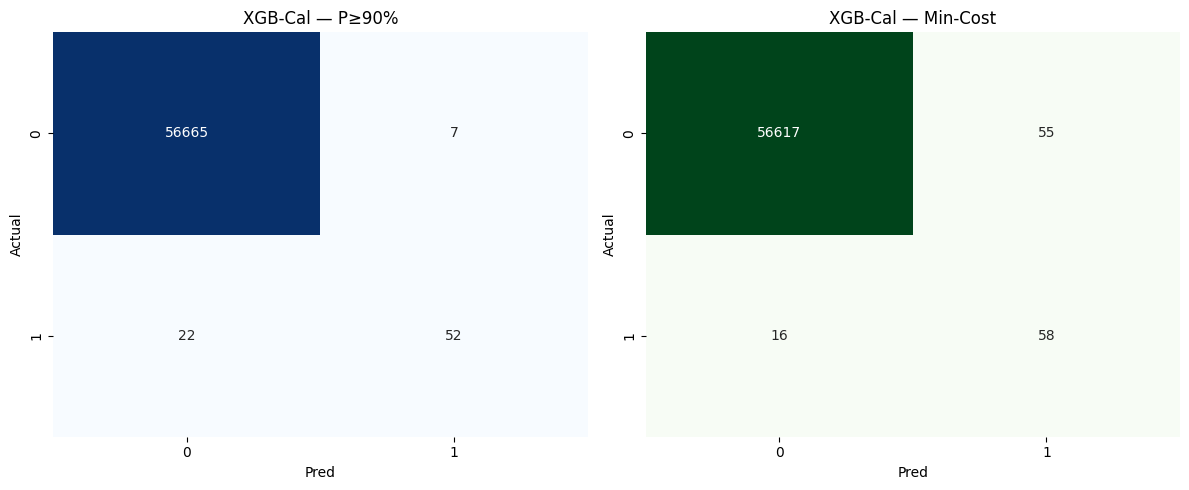

In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, brier_score_loss
import seaborn as sns   


thr_p90_xgb, p_val_xgb, r_val_xgb = thr_for_precision(y_val, val_xgb_cal, target_p=0.90)
thr_cost_xgb, best_cost_val_xgb = thr_min_cost(y_val,  val_xgb_cal, cost_fp=COST_FP, cost_fn=COST_FN)

print(f"[VAL|XGB-Cal] Thr@P≥90%: thr={thr_p90_xgb:.3f}, P={p_val_xgb:.3f}, R={r_val_xgb:.3f}")
print(f"[VAL|XGB-Cal] Thr@Min-Cost: thr={thr_cost_xgb:.3f}, Cost={best_cost_val_xgb:.2f}")

eval_xgb_p90  = evaluate_block(y_test, test_xgb_cal, thr_p90_xgb)
eval_xgb_cost = evaluate_block(y_test, test_xgb_cal, thr_cost_xgb)
cm_xgb_p90  = confusion_matrix(y_test, (test_xgb_cal >= thr_p90_xgb ).astype(int))
cm_xgb_cost = confusion_matrix(y_test, (test_xgb_cal >= thr_cost_xgb).astype(int))

print("\n===== XGB-Cal — TEST EVAL =====")
print("XGB-Cal@Test (Thr@P≥90%):",  eval_xgb_p90)
print("XGB-Cal@Test (Thr@Min-Cost):", eval_xgb_cost)

cost_xgb_p90 = realized_cost(y_test, test_xgb_cal, thr_p90_xgb,  cost_fp=COST_FP, cost_fn=COST_FN)
cost_xgb_min = realized_cost(y_test, test_xgb_cal, thr_cost_xgb, cost_fp=COST_FP, cost_fn=COST_FN)
print(f"[TEST|XGB-Cal] Realized Cost @ P≥90% thr ({thr_p90_xgb:.3f}): {cost_xgb_p90:.2f}")
print(f"[TEST|XGB-Cal] Realized Cost @ Min-Cost thr ({thr_cost_xgb:.3f}): {cost_xgb_min:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_xgb_p90,  annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('XGB-Cal — P≥90%');  axes[0].set_xlabel('Pred'); axes[0].set_ylabel('Actual')
sns.heatmap(cm_xgb_cost, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('XGB-Cal — Min-Cost'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()

In [49]:
def expected_calibration_error(y_true, y_prob, n_bins=15):
    """
    Simple (non-standardized) ECE: weighted avg |acc - conf| over quantized bins.
    For formal comparisons, prefer standardized definitions.
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (idx == b)
        if not np.any(mask):
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

rng = np.random.default_rng(SEED)
def bootstrap_ci(metric_fn, y_true, y_score, B=300, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = np.quantile(vals, alpha/2)
    hi = np.quantile(vals, 1 - alpha/2)
    return float(lo), float(hi)


In [51]:
def summarise_model(name, y_true, y_prob, thr_p90, thr_cost):
    ap = average_precision_score(y_true, y_prob)
    roc = roc_auc_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    ece = expected_calibration_error(y_true.values, y_prob, n_bins=15)
    cost_p90 = realized_cost(y_true, y_prob, thr_p90, COST_FP, COST_FN)
    cost_min = realized_cost(y_true, y_prob, thr_cost, COST_FP, COST_FN)
    ap_lo, ap_hi = bootstrap_ci(average_precision_score, y_true.values, y_prob)
    return {
        "Model": name, "AP(Test)": ap, "AP 95% CI": f"[{ap_lo:.3f}, {ap_hi:.3f}]",
        "ROC-AUC(Test)": roc, "Brier(Test)": brier, "ECE(15)": ece,
        "Thr@P90(val)": float(thr_p90), "Thr@MinCost(val)": float(thr_cost),
        "Cost@Test@P90": cost_p90, "Cost@Test@MinCost": cost_min,
    }

summary_df = pd.DataFrame([
    summarise_model("XGB-Cal", y_test, test_xgb_cal, thr_p90_xgb, thr_cost_xgb),
]).sort_values("AP(Test)", ascending=False)

display(summary_df.round(4))

,Model,AP(Test),AP 95% CI,ROC-AUC(Test),Brier(Test),ECE(15),Thr@P90(val),Thr@MinCost(val),Cost@Test@P90,Cost@Test@MinCost
0,XGB-Cal,0.7588,"[0.660, 0.847]",0.9748,0.0006,0.0006,0.7,0.169,4435.0,3475.0
